# Import Statements
---
**Important note:**
For some reason tensorflow version and numpy version have dependency conflicts. Need to figure out what version is stable for both of these to work together.

In [28]:

import pandas as pd
import glob
import os
import time
import twint
import nest_asyncio                 # Import required for twint usage.
import re
from nltk.corpus import stopwords   # supplied list of words that can be removed from tweets because they carry no sentiment.
nest_asyncio.apply()
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as pypl
import datetime as dt
import pandas_datareader as pdr


from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

## Reading in crypto price dataset
---
Section below reads csv files into pandas dataframes for interacting with. Also compiles list of coin names for twitter searching.

### What to do next:
* Retrieve Token labels from CSV file for searching by Cashtag on twitter.

In [29]:
path = r'c:\Users\WaKaBurd\Documents\GitHub\CryptoPredictionTool\archive'
extension = 'csv'
os.chdir(path)
csv_files = glob.glob('*.{}'.format(extension))

# Compile list of all coin names for searching on twitter later
coins = []

for coin in csv_files:
    vals = coin.split("_")
    coin_name = vals[1][:-4]
    coins.append(coin_name)

# compile list of scaled np arrays for training models later on.
coin_data = []

for file in csv_files:
    df = pd.read_csv(file)
    coin_data.append(df)

print(dt.datetime.now().date())

2022-04-04


## Scrape Twitter for data on all coins supplied by dataset
---
Below section of code searches through twitter using keywords. Uses sift_tweet() function to remove all unnecessary characters, links, emojis & words from tweets. Also uses Textblob to append polarity column to pandas df for tracking sentiment of tweets.

### What to do next:
* Search twitter based on Cashtags & Hashtags
* Configure Twint with Google translater so I can translate tweets from non-english langauges to english. (Need to create ticket for this in Github)

In [31]:
# Need to create function for cleaning the tweets.
def sift_tweet(tweet, stop_words):
    cleaned_tweet = tweet
    cleaned_tweet = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet) # regex to remove all @userame, emojis, and links from tweets.
    for word in cleaned_tweet:
        if word in stop_words: cleaned_tweet.replace(word, '')
    return cleaned_tweet

# Function for iterating through coins list and storing findings in .csv files
def search_coins(coins):
    important_cols = ['date', 'created_at', 'tweet']
    stopwords_file = open("../archive/stopwords.txt", "r+")
    stopwords = list(stopwords_file.read().split('\n'))
    path = r'c:\Users\WaKaBurd\Documents\GitHub\CryptoPredictionTool\search_results'
    os.chdir(path)
    search_result = pd.DataFrame()
    
    for coin in coins:
        print('performing twitter search for coin:', coin)
        
        # TODO: This coin title doesn't really exist on twitter so it yields no results causing errors. Need to fix logic here.
        if coin == "CryptocomCoin":
            continue
    
        timestr = time.strftime("%Y%m%d")

        c = twint.Config()
        c.Limit = 100
        c.Lang = "en"
        c.Pandas = True
        c.Search = coin
        c.Hide_output = True
        twint.run.Search(c)
        coin_df = twint.storage.panda.Tweets_df
        
        # important for when twint fails to find tweets based on currency.
        if coin_df['tweet'] is None:
            continue
        
        # Strip all columns we don't care about.
        for col in coin_df:
            if col not in important_cols: coin_df.pop(col)
        
        coin_df['Processed Tweet'] = coin_df['tweet'].apply(lambda x: sift_tweet(x.lower(), stopwords))       # Lambda function for creating processed tweets in Coin Dataframe 
        coin_df['Polarity'] = coin_df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[0])            # Lambda function for creating Polarity value in Coin Dataframe using Textblob
        
        
        coin_df.to_csv(str(dt.datetime.now().date()) +'-' + coin + '_result.csv')
          
#search_coins(coins)

## Create and Train Neural Net on Dataset
---


### What to do next:
* Bonus Task #1
* Bonus Task #2

In [39]:
prediction_days = 90
scaler = MinMaxScaler(feature_range=(0,1))
def train_model(x_train, y_train):
    # Model Setup
    model = Sequential()
    
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))    # Price prediction

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=15, batch_size=32)
    return model

def scale_and_reshape(data, num_days):
    # Scale and chunk data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
        
    x_train = []
    y_train = []

    # Scale data into chunks of time (in days)
    for x in range(num_days, len(scaled_data)):
        x_train.append(scaled_data[x - num_days:x, 0])
        y_train.append(scaled_data[x, 0])
                
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Reshape Data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    reshaped_data = []
    reshaped_data.append(x_train)
    reshaped_data.append(y_train)
    
    return reshaped_data


#print('coin_data:', coin_data[i]['Close'])
scaled_coin_data = scale_and_reshape(coin_data[0], 90)
trained_model = train_model(scaled_coin_data[0], scaled_coin_data[1])

# Just a reminder, this scaled coin data is a list, comprised of lists of lists. 
# If I want to access AAVE's coin data, I'd need to access scaled_coin_data[0]
# Inside that list, is 215 lists (275 entries in archive/coin/aave - 60 omitted days for our predictions)
# print(len(scaled_coin_data))
# print(scaled_coin_data[0][0])



Epoch 1/15
91/91 [==============================] - 19s 145ms/step - loss: 0.0035
Epoch 2/15
91/91 [==============================] - 13s 140ms/step - loss: 0.0015
Epoch 3/15
91/91 [==============================] - 13s 143ms/step - loss: 0.0012
Epoch 4/15
91/91 [==============================] - 13s 147ms/step - loss: 0.0011
Epoch 5/15
91/91 [==============================] - 14s 151ms/step - loss: 0.0012
Epoch 6/15
91/91 [==============================] - 13s 148ms/step - loss: 0.0011
Epoch 7/15
91/91 [==============================] - 13s 143ms/step - loss: 0.0011
Epoch 8/15
91/91 [==============================] - 13s 148ms/step - loss: 0.0010
Epoch 9/15
91/91 [==============================] - 13s 143ms/step - loss: 9.8616e-04
Epoch 10/15
91/91 [==============================] - 13s 146ms/step - loss: 8.8186e-04
Epoch 11/15
91/91 [==============================] - 13s 143ms/step - loss: 8.8573e-04
Epoch 12/15
91/91 [==============================] - 13s 147ms/step - loss: 7.2995e-

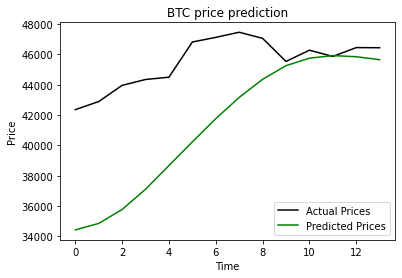

In [45]:
def test_and_plot(coin_data, model):
    test_start = dt.datetime(2022,6,20) + dt.timedelta(days=-prediction_days)
    test_end = dt.datetime.now()
    
    test_data = pdr.DataReader(f'BTC-USD', 'yahoo', test_start, test_end)
    actual_prices = test_data['Close'].values
    
    total_dataset = pd.concat((coin_data['Close'], test_data['Close']), axis=0)
    
    model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
    model_inputs = model_inputs.reshape(-1,1)
    model_inputs = scaler.fit_transform(model_inputs)
    
    x_test = []
    
    for x in range(prediction_days, len(model_inputs)):
        x_test.append(model_inputs[x-prediction_days:x, 0])
        
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    prediction_prices = model.predict(x_test)
    prediction_prices = scaler.inverse_transform(prediction_prices)
    
    pypl.plot(actual_prices, color='black', label='Actual Prices')
    pypl.plot(prediction_prices, color='green', label='Predicted Prices')
    pypl.title(f'BTC price prediction')
    pypl.xlabel('Time')
    pypl.ylabel('Price')
    pypl.legend(loc='lower right')
    pypl.show()

test_and_plot(coin_data[0], trained_model)